# Normalization & PCA

## Introduction

Single cell data is __messy__. It often contains noise from technical artefacts, batch effects, and other confounders. Before analyzing our data, we need to assess and correct for as much of this unwanted variation as possible.

There are sophisticated methods for correcting complex sources of variation; we refer to the excellent guide [here](https://www.embopress.org/doi/full/10.15252/msb.20188746) for an overview. In this tutorial, we'll focus on the most fundamental sources of unwanted variation, and simple but effective ways to handle this.

## Load data

We'll continue to work with the output of our previously QC'd tabula muris senis brain dataset, and use PCA to visualize the results.

In [1]:
import scanpy as sc

In [2]:
adata = sc.read('../data/brain_qc.h5ad')

## Principle components analysis

__Dimensionality reduction methods__ seek to take a large set of variables and return a smaller set of __components__ that still contain most of the information in the original dataset.

One of the simplest forms of dimensionality reduction is __[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)__. Principal component analysis (PCA) is a mathematical procedure that transforms a number of possibly correlated (e.g., expression of genes in a network) variables into a (smaller) number of uncorrelated variables called __principal components ("PCs")__.

Mathematically, the PCs correspond to the eigenvectors of the covariance matrix. The eigenvectors are sorted by eigenvalue so that the first principal component accounts for as much of the variability in the data as possible, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components (the figure below is taken from [here](http://www.nlpca.org/pca_principal_component_analysis.html)).

<img src="../figures/pca.png" alt="PCA" style="width: 500px;"/>

Now that we have a clean expression matrix, we can use PCA to visualize an overview of the data and assess confounding factors. `SCANPY` provides several very useful functions to simplify visualisation.

Let's first peek at our data before normalization:

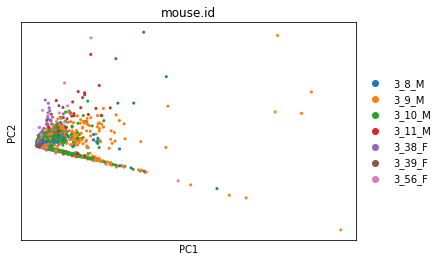

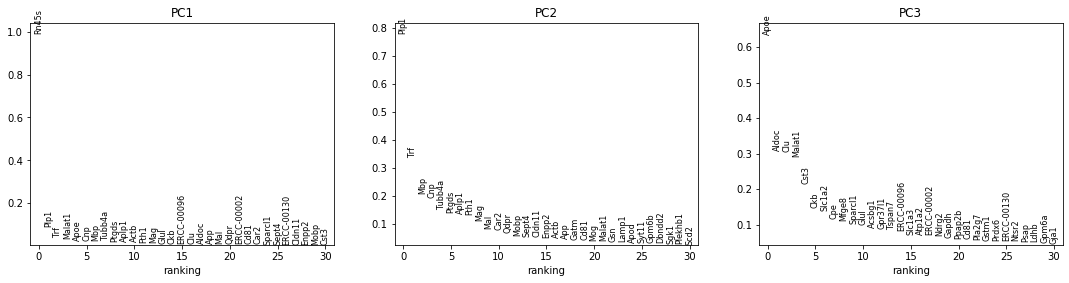

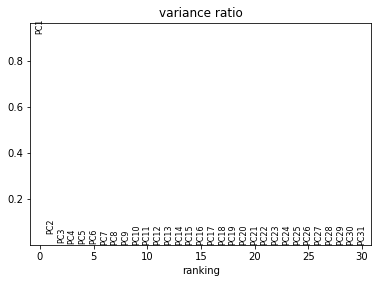

In [3]:
sc.pp.pca(adata)
sc.pl.pca_overview(adata, color='mouse.id')

The first plot has a strange, very linear first PC (which captures the most variation in the dataset). This suggests that we have outliers in our data. 

The next row of plots shows the __loadings__, which indicate how strongly each variable in the original data contributes to each principle component. Here, we see that the first PC is strongly determined by the expression of just a small number of genes.

The bottom plot shows us that the first principle component captures the vast majority of the variation in the raw data. 

## Normalizing cell library size

Library sizes vary because scRNA-seq data is often sequenced on highly multiplexed platforms, and the total reads which are derived from each cell may differ substantially. Some quantification methods
(eg. [`Cufflinks`](http://cole-trapnell-lab.github.io/cufflinks/), [`RSEM`](http://deweylab.github.io/RSEM/)) incorporate library size when determining gene expression estimates and thus do not require this normalization. However, if another quantification method was used then library size must be corrected for. 

There are two main approaches to this correction. Many methods use a simple linear scaling to adjust counts such that each cell (row) has about the same total library size. Examples include converting to counts per million (`CPM`) and closely related methods such as `scran`. While simple, these approaches do a reasonable job of correcting for differences in library size.   
  
Other methods are more complex, and generally involve parametric modeling of count data to perform nonlinear normalization. These methods are useful when there are more complex sources of unwanted variation (e.g., for highly heterogeneous populations of cells with different sizes).

In this lesson, we'll stick to the simple, linear scaling methods. We recommend reviewing [Cole et al., 2019](http://scholar.google.com/scholar_lookup?hl=en&volume=8&publication_year=2019&pages=315-328&journal=Cell+Syst&author=MB+Cole&author=D+Risso&author=A+Wagner&author=D+DeTomaso&author=J+Ngai&author=E+Purdom&author=S+Dudoit&author=N+Yosef&title=Performance+assessment+and+selection+of+normalization+procedures+for+single%E2%80%90cell+RNA%E2%80%90seq) for an in-depth comparison of normalization methods. 

### CPM

The simplest way to normalize this data is to convert it to counts per
million (__CPM__) by dividing each row by a **size factor** (the sum of all counts in the row), then multiplying by
1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA. 

In [4]:
adata_cpm = adata.copy() # apply this to a copy so we can compare methods
adata_cpm.raw = adata_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_cpm, 
                         counts_per_cell_after=1e6)

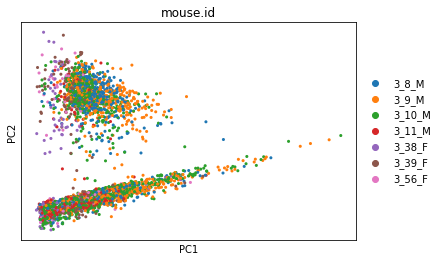

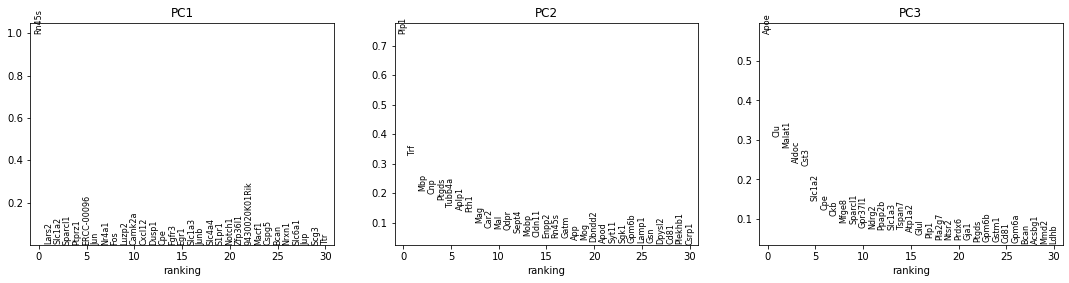

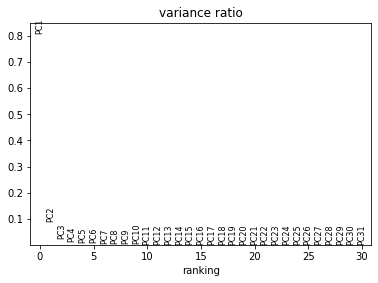

In [5]:
sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='mouse.id')

A potential drawback of __CPM__ is if your sample contains genes that are both very highly expressed and differentially expressed across the cells. In this case, the total molecules in the cell may depend of whether such genes are on/off in the cell and normalizing by total molecules may hide the differential expression of those genes and/or falsely create differential expression for the remaining genes. One way to mitigate this is to exclude highly expressed genes from the size factor estimation. 

### Exercise  

Use the SCANPY function `sc.pp.normalize_total()` to normalize with counts per million, excluding highly expressed genes from the size factor calculation. 

Visualize the output with PCA. How much difference did this make? Which method do you prefer for this dataset? 

<p>
<details>
<summary><h3>Solution</h3></summary>
<code style=display:block;white-space:pre-wrap>adata_cpm_ex = adata.copy() # make a copy so we can compare results
sc.pp.normalize_total(adata_cpm_ex, target_sum=1e6, exclude_highly_expressed=True) # normalize
sc.pp.pca(adata_cpm_ex) # run pca
sc.pl.pca_overview(adata_cpm_ex) # plot pca</code>
<p/>
This is more reasonable than before: the second component now explains some of the variance.
</details>
</p>

In [ ]:
help(sc.pp.normalize_total)

Other linear approaches to correcting for library size include:  
* Downsampling, which randomly samples reads from each cell until a set threshold is reached
* RPKM and related methods, which correct for transcript length  

While we won't take the time to walk through these today, you can see a head-to-head comparison [here](https://scrnaseq-course.cog.sanger.ac.uk/website/cleaning-the-expression-matrix.html#normalisations). 

## Normalizing gene expression

As we saw earlier, this dataset is dominated by a small number of highly expressed genes.

One way to address this is by __centering and scaling__ the gene expression values (you may remember a "z-score" from stats class). Importantly, doing this places an equal weight on each gene for downstream analysis. Depending on your biological question, this may or may not be appropriate. The advantage of doing so, however, is that it de-emphasizes the small handful of genes that are differentially expressed at high levels, which are currently dominating the data. 

First, we take the log(1+x) of each value. The +1 makes sure that 0 values in the original data still map to 0 in log space (and prevents us from trying to take the log of 0). This makes the expression values more closely approximate a Gaussian distribution, which is an assumption inherent to many downstream analysis methods. 

Then for each gene, we subtract the mean expression value and divide by the standard deviation.

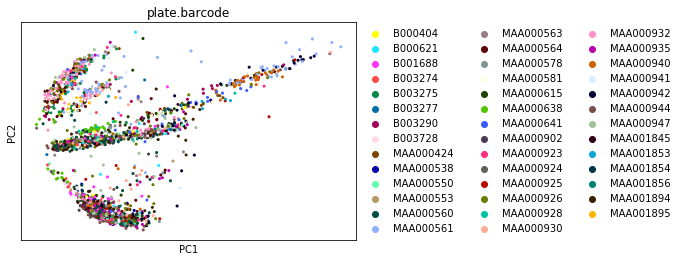

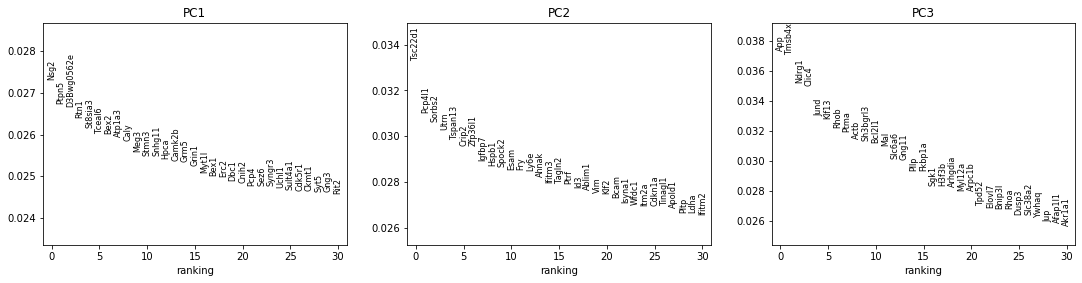

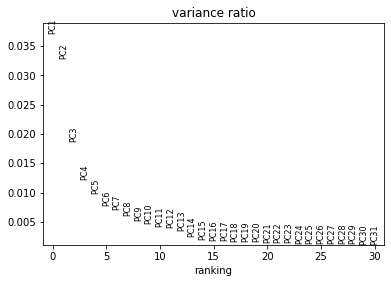

In [6]:
sc.pp.log1p(adata_cpm)
sc.pp.scale(adata_cpm)

sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='plate.barcode')

This looks much better: the first plot shows more Gaussian-looking groups of cells. The second row of plots shows well-distributed loadings, indicating that each PC is driven by multiple genes. And the final plot shows that Each of the first ~5-10 components captures some of the variance in the data. 

Let's write our normalized data to file for later use.

In [19]:
adata_cpm.write('../data/brain_normalized.h5ad')